In [239]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import Fetch_FS
import Fetch_Here

In [211]:
%%time
final = set()
for i in range(1000, 21000, 1000):
    final = final.union(Fetch_Here.get(i))
resd = dict()
resd['name'] = []
resd['lat'] = []
resd['lon'] = []
for (x,y,name) in final :
    resd['lat'].append(x)
    resd['lon'].append(y)
    resd['name'].append(name)
tdf = pd.DataFrame.from_dict(resd)
tdf.to_csv('ResidentialAreas_' + "Here" + '.csv',index=0)
print("Residential Areas Marked")

Residential Areas Marked
CPU times: user 549 ms, sys: 159 ms, total: 708 ms
Wall time: 11.1 s


In [212]:
%%time
from time import sleep
import os
resd_cnt = dict()
resd_cnt['lat'] = tdf['lat']
resd_cnt['lon'] = tdf['lon']
for name in req_cat.keys():
    tmp = []
    for (x,y) in zip(tdf['lat'],tdf['lon']):
        tmp.append(get_cat(x,y,req_cat[name]))
        sleep(0.2)
    resd_cnt[name]=tmp
rdf = pd.DataFrame.from_dict(resd_cnt)
rdf.to_csv("ResidentialAreasNeighbourhood_"+ "Here" +".csv",index=0)
print("Neighbourhood of Each Residential Building Marked")

Neighbourhood of Each Residential Building Marked
CPU times: user 17.7 s, sys: 1.76 s, total: 19.4 s
Wall time: 8min 16s


In [213]:
rdf.head()

,lat,lon,Eat and Drink,Entertainment,Transport,Leisure,Shopping,Services,Facilities
0,28.64192,77.29594,100,22,28,20,100,100,100
1,28.63145,77.29378,58,24,8,3,100,100,100
2,28.63768,77.28574,100,55,38,53,100,100,100
3,28.63790,77.30080,87,29,5,8,100,100,100
4,28.64135,77.29466,100,23,27,19,100,100,100


In [214]:
X = np.array(rdf.drop(['lat','lon'],axis=1))
X = np.stack(X)

In [215]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

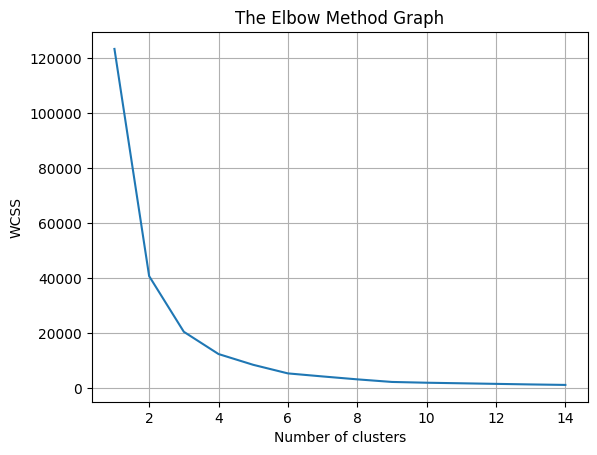

In [216]:
wcss = []
maxsize = 15
for cluster_size in range(1,maxsize):
    kmeans = KMeans(n_clusters=cluster_size, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,maxsize),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [217]:
optimal = 3
kmeans = KMeans(n_clusters=optimal, init='k-means++', max_iter=1000, n_init=125, random_state=0)
y_kmeans = kmeans.fit_predict(X_pca)
rdf['cluster']=y_kmeans

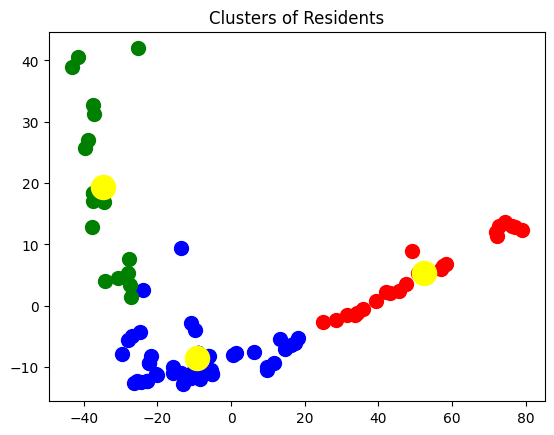

In [218]:
plt.scatter(X_pca[y_kmeans==0, 0], X_pca[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_pca[y_kmeans==1, 0], X_pca[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_pca[y_kmeans==2, 0], X_pca[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of Residents')
plt.show()

In [219]:
mapping = dict()
for name,x,y in zip(tdf.name,tdf.lat,tdf.lon):
    mapping[(x,y)]=name

In [220]:
import folium
this_map = folium.Map(prefer_canvas=True)
latlon = [(x,y,c) for x,y,c in zip(rdf['lat'],rdf['lon'],rdf['cluster'])]
coloring = {0:'red', 1:'blue', 2:'green'}
for coord in latlon:
    folium.CircleMarker(location=[coord[0], coord[1]],
                        radius=2,
                        weight=5,
                        color=coloring[coord[2]],
                        popup=mapping[(coord[0],coord[1])]).add_to(this_map)
this_map.fit_bounds(this_map.get_bounds())
this_map

In [233]:
from minisom import MiniSom
input_size = X.shape[1]
som = MiniSom(x=3, y=1, input_len=input_size, sigma=0.7, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, 100)
cluster_labels = np.zeros(len(X))
for i, x in enumerate(X):
    cluster_labels[i] = int(som.winner(x)[0] + som.winner(x)[1] * 3)

In [234]:
rdf['cluster'] = cluster_labels
rdf['cluster'] = rdf['cluster'].astype(int)
rdf['cluster'].values

array([2, 0, 1, 0, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 0,
       2, 2, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1,
       0, 0, 1, 1, 1, 2, 2, 1, 2, 2, 0, 0])

In [235]:
latlon = [(x,y,c) for x,y,c in zip(rdf['lat'],rdf['lon'],rdf['cluster'])]

map = folium.Map(prefer_canvas=True)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'blueviolet', 'cyan', 'magenta', 'yellow', 'tan', 'aquamarine', 'salmon']

for coord in latlon:
    folium.CircleMarker(location=[coord[0], coord[1]],
                        radius=2,
                        weight=5,
                        color=colors[coord[2]],
                        popup=mapping[(coord[0],coord[1])]).add_to(map)
map.fit_bounds(this_map.get_bounds())
map

In [236]:
som_size = (3,1)
features = ['Restaurant' , 'Fruit and Vegetable', 'Grocery Store' , 'Health and Medicine', 'Sweets and Snacks', 'Metro Station']
cluster_means = np.zeros((som_size[0], som_size[1], X.shape[1]))
for i in range(len(X)):
    w = som.winner(X[i])
    cluster_means[w[0], w[1], :] += X[i]
for i in range(som_size[0]):
    for j in range(som_size[1]):
        if np.sum(cluster_means[i, j, :]) > 0:
            cluster_means[i, j, :] /= np.sum(cluster_means[i, j, :])

for i in range(som_size[0]):
    for j in range(som_size[1]):
        print(f'Cluster ({i}, {j}):')
        for k, feature in enumerate(features):
            print(f'{feature}: {cluster_means[i, j, k]}')
        print('\n')

Cluster (0, 0):
Restaurant: 0.17938833204831664
Fruit and Vegetable: 0.06228047631285873
Grocery Store: 0.026899683029212713
Health and Medicine: 0.011822153687997944
Sweets and Snacks: 0.23986978497387132
Metro Station: 0.23986978497387132


Cluster (1, 0):
Restaurant: 0.17548057749062773
Fruit and Vegetable: 0.09140942809284518
Grocery Store: 0.07378160644492303
Health and Medicine: 0.1328866554997208
Sweets and Snacks: 0.17548057749062773
Metro Station: 0.17548057749062773


Cluster (2, 0):
Restaurant: 0.20677852909257868
Fruit and Vegetable: 0.07646715084731613
Grocery Store: 0.050755488772017694
Health and Medicine: 0.03990316387010602
Sweets and Snacks: 0.20869855580599384
Metro Station: 0.20869855580599384




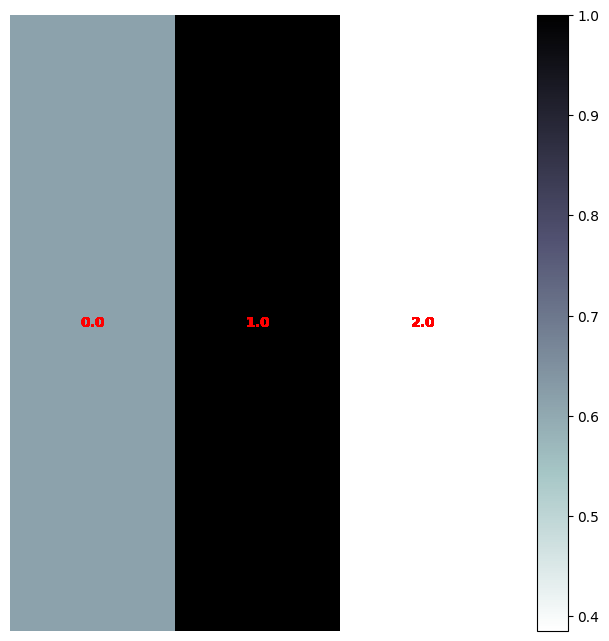

In [237]:
plt.figure(figsize=(8,8))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
for i, x in enumerate(X):
    w = som.winner(x)
    plt.text(w[0]+0.5, w[1]+0.5, str(cluster_labels[i]), color='red', fontweight='bold', ha='center', va='center')
plt.axis('off')
plt.show()

In [238]:
map.save("results_minisom.html")
this_map.save("results_kmeans.html")